In [1]:
import os
import glob
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation # 오늘 사용할 semantic_segmentation
from matplotlib import pyplot as plt


In [2]:
img_dir=os.getenv('HOME')+'/aiffel/human_segmentation/images'
img_path=[i for i in glob.iglob(os.getenv('HOME')+'/aiffel/human_segmentation/images/*.jpg') if 'cat' not in i]
cat_img_path=[i for i in glob.iglob(os.getenv('HOME')+'/aiffel/human_segmentation/images/*.jpg') if 'cat' in i]
output_path=[os.path.join(img_dir,"output","_".join(["sementic",i.split("/")[-1]])) for i in img_path]
cat_output_path=[os.path.join(img_dir,"output","_".join(["sementic",i.split("/")[-1]])) for i in cat_img_path]

background=os.getenv('HOME')+'/aiffel/human_segmentation/background/background.png'
background_dir=os.getenv('HOME')+'/aiffel/human_segmentation/background/'


# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fe48e863ee0>)

Pascalvoc 데이터의 label

In [3]:
LABEL_NAMES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
               'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
               'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
len(LABEL_NAMES)

21

In [4]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:5]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128]])

In [5]:
print(LABEL_NAMES[15],"-",colormap[15]) # LABEL_NAMES와 colormap의 인덱스가 서로 매칭

person - [192 128 128]


### DeepLab모델과 PixelLib

[Semantic segmentation of images with PixelLib using Pascalvoc model](https://pixellib.readthedocs.io/en/latest/Image_pascal.html)

In [15]:
model=semantic_segmentation()
model.load_pascalvoc_model(model_file)

def read_img(img_path):
    return cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

def making_mask(class_id,img_path, model=model): # DeepLAB모델을 사용해서 마스크 만듦
    segvalues, output= model.segmentAsPascalvoc(img_path)
    if class_id in segvalues["class_ids"]:
        seg_color=list(reversed(colormap[class_id].tolist()))
        # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
        seg_map = np.all(output==seg_color, axis=-1) # seg_
        img_mask=seg_map.astype(np.uint8)*255 # 배경은 0, 세그먼트 된 픽셀은 255
        return img_mask
    else:
        print("해당하는 객체가 없습니다")

def blurring_bg(img_path,img_mask, kernel_size): # 배경에 blur를 적용해서 
    img=read_img(img_path)
    img_orig_blur=cv2.blur(img, (kernel_size, kernel_size)) # kernel 사이즈가 커질 수록 blur가 커짐
    img_mask_color=cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # mask를 BGR로 바꿈
    img_bg_mask=cv2.bitwise_not(img_mask_color) # 세그먼트 된 픽셀은 0, 배경은 255
    img_bg_blur=cv2.bitwise_and(img_orig_blur, img_bg_mask) 
    # blur된 이미지를 배경마스킹된 이미지와 and연산해서 배경만 남기고 segment된 객체는 검은색(0).
    img_bg_blur=cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB)
    return img_mask_color,img_bg_blur

def add_photo(img_mask_color, img_bg_blur, img_orig):   # 블러처리 된 배경과 원본이미지를 마스크를 통해서 합치기
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) 
    # img_orig 중에서 img_mask_color가 255인 (배경) 인덱스를 img_bg_blur로 바꿔라
    return cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)

def composite_photo(img_path,class_id,kernel_size=13, model=model): # 지금까지 작성된 함수를 합친 함수
    img_mask=making_mask(class_id, img_path, model=model)
    img_mask_color,img_bg_blur=blurring_bg(img_path, img_mask, kernel_size=kernel_size)
    return add_photo(img_mask_color, img_bg_blur, cv2.cvtColor(read_img(img_path),cv2.COLOR_BGR2RGB))


### 루브릭1. 인물모드 사진을 성공적으로 제작하였다.
- 아웃포커싱 효과가 적용된 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.

------------------------------------------------
- 인물사진 아웃포커싱

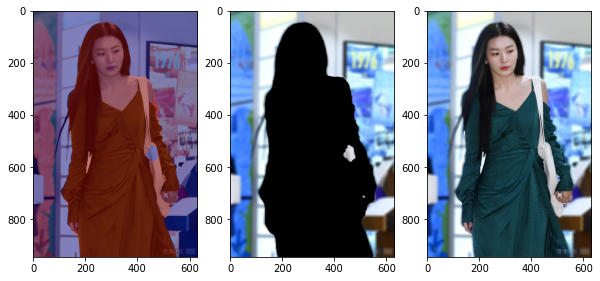

In [7]:
plt.figure(figsize=(10,8))
for idx,img in enumerate(img_path[:1]):
    img_show=read_img(img)
    img_orig=read_img(img)
    img_mask=making_mask(15, img)  # 15: (탐지하려는 객체의 클래스/ 사람 15), img : 이미지의 경로
    
    plt.subplot(1,3,idx+1)
    color_mask=cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) 
    # 입력데이터에 맞게 특정 컬러 값이 mapping: 0인 픽셀과 255인 픽셀에 서로 다른 값 들어감
    img_show = cv2.addWeighted(img_show, 0.5, color_mask, 0.5, 0.0)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    
    plt.subplot(1,3,idx+2)
    img_mask_color,blurring_=blurring_bg(img, img_mask, 13)   # 배경은 블러처리하고 객체(사람)이 있는 자리는 검은색으로 마스크 만들기
    plt.imshow(cv2.cvtColor(blurring_, cv2.COLOR_BGR2RGB))
    
    plt.subplot(1,3,idx+3)
    CP=add_photo(img_mask_color, blurring_, cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)) 
    # 블러처리한 배경과 객체 합친 이미지
    plt.imshow(CP)

가장 왼쪽은 이미지의 배경은 파란색, 사람은 주황색으로 분류해서 컬러 마스크를 씌운 것이고 가운데 이미지는 배경에 blur를 입히고, 마스킹된 사람을 0으로 연산한 이미지이다. 가장 오른쪽은 합성이 끝난 이미지이다.

- 고양이 사진 아웃포커싱

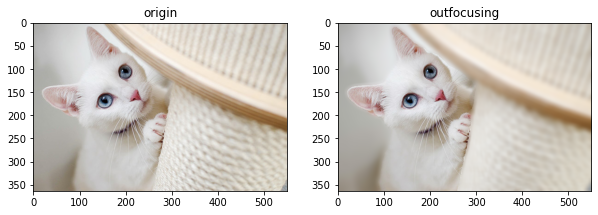

In [8]:
plt.figure(figsize=(10,10))
cat_cp=composite_photo(cat_img_path[0], class_id=8) # 고양이 사진의 주소와 고양이 클래스(8)
plt.subplot(1,2,1)
plt.imshow(read_img(cat_img_path[0]))
plt.title("origin")
plt.subplot(1,2,2)
plt.imshow(cat_cp)
plt.title("outfocusing")
plt.show()

- 배경 바꾸기(인물)

(945, 630, 3) (945, 630, 3)


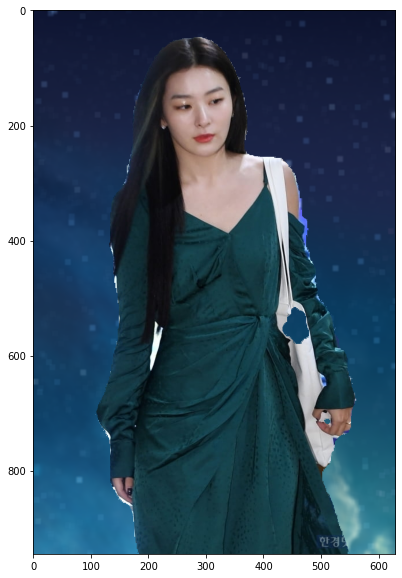

In [9]:
mask=making_mask(class_id=15, img_path=img_path[0])
bg=read_img(background)
bg=bg[0:mask.shape[0],0:mask.shape[1]]   # 배경이미지를 인물 사진의 크기와 맞춰준다.
background_dir=os.getenv('HOME')+'/aiffel/human_segmentation/background/bg1.png'

cv2.imwrite(background_dir, bg)
img_mask_color, img_bg_blur = blurring_bg(background_dir,mask,kernel_size=10)
print(img_mask_color.shape, img_bg_blur.shape)

c=add_photo(img_mask_color, cv2.cvtColor(img_bg_blur,cv2.COLOR_BGR2RGB), cv2.cvtColor(read_img(img_path[0]),cv2.COLOR_BGR2RGB))
plt.figure(figsize=(10,10))
plt.imshow(c)
plt.show()

- 배경 바꾸기(고양이)

(364, 550, 3) (364, 550, 3)


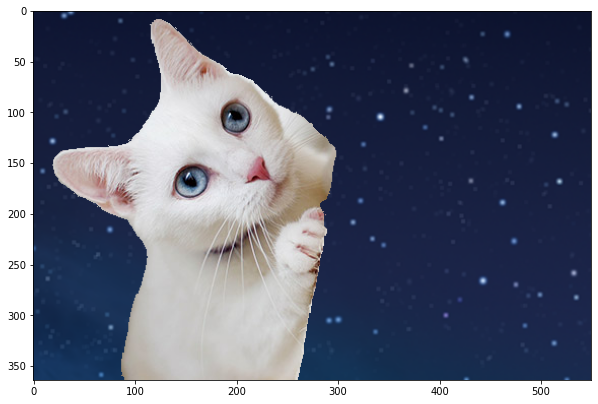

In [10]:
mask=making_mask(class_id=8, img_path=cat_img_path[0])
bg=read_img(background)
bg=bg[0:mask.shape[0],0:mask.shape[1]]   # 배경이미지를 인물 사진의 크기와 맞춰준다.
background_dir=os.getenv('HOME')+'/aiffel/human_segmentation/background/cat_bg1.png'

cv2.imwrite(background_dir, bg)
img_mask_color, img_bg_blur = blurring_bg(background_dir,mask,kernel_size=4)
print(img_mask_color.shape, img_bg_blur.shape)

c=add_photo(img_mask_color, cv2.cvtColor(img_bg_blur,cv2.COLOR_BGR2RGB), cv2.cvtColor(read_img(cat_img_path[0]),cv2.COLOR_BGR2RGB))
plt.figure(figsize=(10,10))
plt.imshow(c)
plt.show()

문제점을 찾기 위해서 여러개의 사진에 모델을 적용시켜보았다.

In [12]:
len(img_path)

9

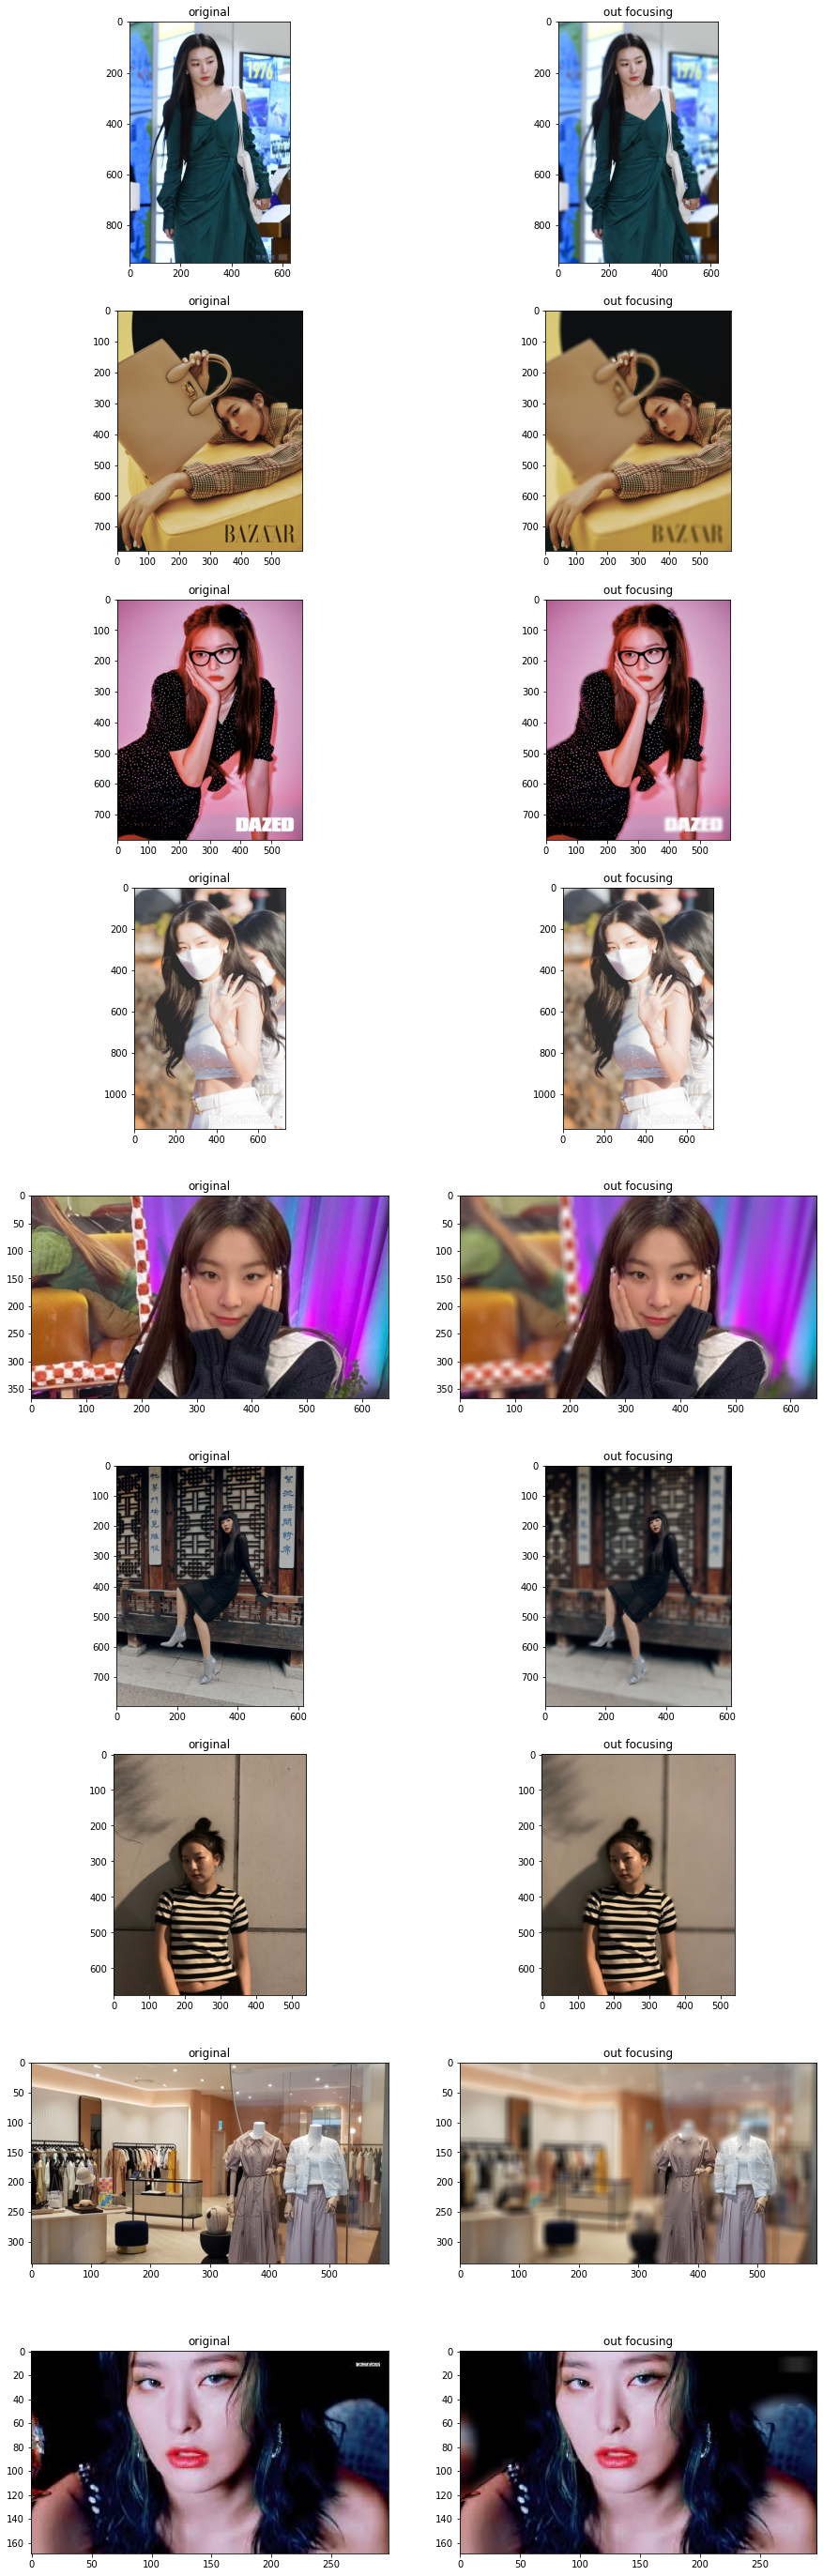

In [19]:
plt.figure(figsize=(15,50))
i=0
for idx,img in enumerate(img_path):
    mp=composite_photo(img, class_id=15) # 아웃포커싱 함수
    plt.subplot(9,2,i+1)
    plt.imshow(read_img(img))
    plt.title("original")
    plt.subplot(9,2,i+2)
    plt.imshow(mp)
    plt.title("out focusing")
    i+=2
plt.show()

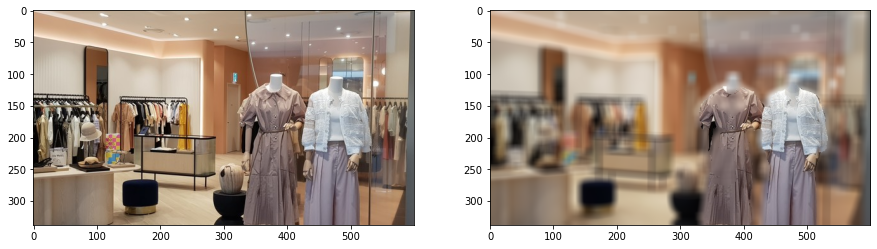

In [18]:
plt.figure(figsize=(15,20))
img=img_path[-2]
mp=composite_photo(img, class_id=15)

plt.subplot(1,2,1)
plt.imshow(read_img(img))
plt.subplot(1,2,2)
plt.imshow(mp)
plt.show()

### 루브릭 2. 문제점 찾기
- sementic segmentation의 문제점을 찾기 위해서 다양한 사이즈의 인물 사진과 마네킹사진을 테스트해보았다.
#### 문제점 1. 사람의 외곽선을 정확하고 깨끗하게 마스킹하지 못한다.

<img src="https://github.com/Asunny2019/AIFFEL_Exploration/blob/main/img/test2.JPG?raw=true" width="600" height="400"/>
<img src="https://github.com/Asunny2019/AIFFEL_Exploration/blob/main/img/test1.JPG?raw=true" width="600" height="400"/>
<img src="https://github.com/Asunny2019/AIFFEL_Exploration/blob/main/img/test4.JPG?raw=true" width="600" height="400"/>

- 가장 위쪽에 있는 사진을 보면 가장 뒤에 있는 얼굴과 가장 앞에 있는 뻗은 손은 둘다 사람으로 인식이 되어서 포커스가 잘 맞지만 손가락은 사람으로 인식이 되지 못해서 포커스가 전혀 맞지 않았다. 즉, 우리가 원하는 심도에 위치한 물건을 포커스 인하고 나머지의 물체를 포커스 아웃 시키는게 아니라 sementic segmentation 정확도가 높은 곳에 포커싱이 되는 결과를 가져오게 된다. 
- 두번째 사진도 사람의 커다란 몸통이나 얼굴면과 같이 면적은 정확하게 사람으로 예측해냈지만, 사람의 외곽선(배경이 만나는 지점)을 깨끗하게 마스킹하지 못해서 새로운 배경에 붙여넣기를 했을때 인물사진의 원본 사진의 배경이 일부 남아있어서 부자연스러운 이미지가 만들어진다.
- 가장 위쪽 사진의 경우 클로즈업된 사진이라서 손가락과 같이 섬세한 부분이 탐지가 안되는 것인가 궁금해서 풀샷의 이미지를 테스트 해보았다. 풀샷의 경우도 화살표로 가르켜진 팔부분이 탐지가 되지 않아서 포커스 아웃이 된 것을 알수 있다. 

#### 문제점 2. 근처에 있는 같은 사람도 포커싱 되어버린다.
<img src="https://github.com/Asunny2019/AIFFEL_Exploration/blob/main/img/test3.JPG?raw=true" width="600" height="400"/>

- 심도를 얕게 가져가서 포커스 아웃을 하는 이유는 사진 안에서 내가 보여주고자 하는 대상만 화면의 집중이 되게 하는게 목표이다. 하지만 옆에 있는 사람도 함께 focus- in이 되어서 원하지 않는 그림이 그려지게 된다.  

- 아마도 __sementic segmentation은 같은 객체들 간에 구분을 하지 않아서, 옆에 있는 사람을 하나의 사람으로 묶어서 표현__ 하여서 나눠서 실제 아웃포커싱하는 방식으로 표현이 되지 않는 것 같다.

#### 문제점 3. 마네킹을 사람으로 인식해버린다.
<img src="https://github.com/Asunny2019/AIFFEL_Exploration/blob/main/img/test5.JPG?raw=true" width="1000" height="500"/>

- 사람의 경우는 얼굴이 없는 마네킹을 사람으로 보는 경우가 거의 없지만, sementic segmentation이 픽셀들이 사람의 객체에 속하는지 배경에 속하는지 확률적으로 따지기 때문일까. 마네킹의 대부분을 사람으로 인식하고 있다.  
- 아마도 수집하는 대부분의 이미지가 사람들이 옷을 입고 있기 때문에 옷을 사람이라고 인식하는 것이 아닐까 생각이 들었다. 이미지의 전체적인 윤곽을 따지지 않는 것은 아니겠지만, 이런 이유로 옷을 입고 있는 것과 마네킹에 옷을 걸친 것을 구분을 해내지 못하는 것이 아닐까 생각해보았다. exploration의 노드에서도 의자에 걸쳐진 옷자락을 사람의 일부로 속하게 만든 것과 비슷한 문제라고 생각이 들어서 마네킹도 혹시 분류를 잘 못할까 궁금해서 시도해보았다. 실제로도 구분을 잘하지는 못하는 것 같다.

### 루브릭 3 . 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다

#### 문제점 1 & 문제점 2
![](https://github.com/Asunny2019/AIFFEL_Exploration/blob/main/img/flow_chart.JPG?raw=true)

- struct2Depth를 사용해서 객체의 depth를 측정해낸다음에 내가 원하는 depth안에 들어오는 객체만 골라내에서 focus in 을 시키고 나머지는 focus out을 시킨다.


#### 문제점 3
![](https://github.com/Asunny2019/AIFFEL_Exploration/blob/main/img/flow_chart1.JPG?raw=true)

- 마네킹을 사람으로 인식하는 문제는 지난 EX03에서 작업했던 얼굴을 탐지하는 dlib라이브러리의 face detection을 사용해서 얼굴을 탐지한다. pixellib의 사람이 탐지되는 위치와 face detection 탐지되는 위치가 서로 겹치는지 체크한다. 둘이 겹친다면 사람으로 보고 둘이 겹치지 않는다면 마네킹 혹은 옷으로 취급해서 마스킹에서 지워낸다.


### 후기


- 루브릭 3의 문제점 1의 해결점을 depth 정보가 주어지면 따라서 depth 안에 포함되는 객체에만 포커싱하는 것이 자연스러운게 맞다. 하지만 사람 이미지의 (머리카락, 팔, 다리, 손가락)경계선이 탐지가 잘 안되어서 부자연스러운 문제는 depth 정보만으로는 해결이 안될 것 같다. 데이터를 체크해볼 것 같다. pascal voc의 semantic segmentation 데이터의 라벨링이 적절하게 잘 되었는지 체크해볼 것 같다. 이미지 데이터를 라벨링 할때 적절하게 점을 찍어서 경계선을 부드럽게 잘 체크되었는지 본다. 사람을 라벨링할떼 뒷배경이 너무 많이 들어간건 아닌지 체크해볼 것 같다. 박스를 그려서 라벨링하는 것 보다는 수공이 많이 가는 라벨링작업이라서 데이터의 노이즈가 많이 들어가서 사람에 배경이 들어간 것일수도 있기 때문이다.
- HOG+SVM을 사용했을 때는 얼굴이 일부 화면에서 잘리거나, 얼굴의 한쪽 면만 보이는 경우는 얼굴 인식이 잘 안되었다. 그에 반해서 semantic segmentation은 이런 경우에도 구분을 잘해내는 것을 확인 할수 있었다. 루브릭2를 수행하기 위해서 문제점을 찾아내기는 했지만 다양한 각도에서도 사람의 픽셀을 잘 찾아내는 것을 알 수 있다. 기계학습을 통해서 내가 찾고자 하는 객체의 특징을 이미지 알고리즘을 통해 뽑아내어서 분류해내는 것보다는 딥러닝의 랜덤하게 만들어진 filter를 학습을 통해서 이미지의 특징을 뽑아내는 것이 더 성능이 좋다는 것을 알수 있었다.
![](https://github.com/Asunny2019/AIFFEL_Exploration/blob/main/img/test7.JPG?raw=true)
![](https://github.com/Asunny2019/AIFFEL_Exploration/blob/main/img/test8.JPG?raw=true)

- [E01-가위바위보 프로젝트](https://github.com/Asunny2019/AIFFEL_Exploration/blob/main/E01_rock_scissor_paper.ipynb)는 한장의 사진에 가위, 바위, 보가 있고 분류(classification)해내었다. [E02-카메라 스티커](https://github.com/Asunny2019/AIFFEL_Exploration/blob/main/%5BE-03%5Dcamera_sticker.ipynb)는 한장의 사진에 얼굴의 위치를 찾아내(localization)고 더 들어가서 얼굴 안에 랜드마크를 찾아내는 pre-trained모델(HOG+SVM)을 사용했다. 이번 과제는 전체 이미지 중에서 사람에 해당하는 픽셀을 분류하고 위치를 찾아내는 고난이도의 작업이라고 생각이 들었다.
- 고난이도의 작업이긴하지만 하나의 객체를 각각으로 찾아내는 것이 아니라 사람의 픽셀을 찾아내는 작업이다 보니까 사람의 전체적인 특징을 보지는 못한다는 특징이 있는 것 같다. 그래서 문제점3과 같이 마네킹을 사람이라고 분류해내는 오류가 발생한 것으로 보인다. 
- 문제점 2의 뒤의 있는 사람과 앞에 있는 사람을 구분 못하는 것은 depth 정보를 사용하는 것도 방법이지만 instance segmentation을 활용해서 각 사람의 객체를 분류해내고 UI로 포커스 아웃 시킬 객체를 구분해내는 방법도 해결방법이라고 생각이 든다.